# Acknowledgments

This material is adapted from the blog post from  [Hugging Face on Probablistic Forecasting](https://huggingface.co/blog/time-series-transformers)

## Exercise
- Train your vanilla transformer to see how it performs on different univariate datasets. Start with the following three:
    - tourism_quarterly
    - traffic_weekly
    - 
- Compare with the [Monash Time Series Forcasting Leaderboard](https://forecastingdata.org/#results) to see where your transformer stands.
- Contemplate and discuss with your peers if you can improve the results to come closer or beat the leading algorithm


## Loading dataset

In [10]:
from datasets import load_dataset
dataset = load_dataset("monash_tsf","traffic_weekly")

Generating train split:   0%|          | 0/862 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/862 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/862 [00:00<?, ? examples/s]

- Dataset is split in `train`, `test` and `validation` sets
- Each of the three datasets are dictionaries. Let's explore the values of `start` and `target` keys

In [11]:
train_example = dataset['train'][0]
train_example.keys()

dict_keys(['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'])

In [12]:
print(train_example['start'])

2015-01-01 00:00:00


The `start` indicates the start of the time series and `target` contains the actual values of the time series.

The `start` will be used to add the time related features to the time series values, as extra input to the model. Since this is `monthly` data, we know that each element of the values array corresponds to a month's data.

In [13]:
print(train_example['target'])
print(len(train_example['target']))


[6.487500190734863, 7.809199810028076, 6.8881001472473145, 7.161300182342529, 8.306500434875488, 7.722300052642822, 7.23960018157959, 7.296800136566162, 7.086699962615967, 8.39739990234375, 7.970900058746338, 8.65719985961914, 7.753399848937988, 7.309100151062012, 6.70550012588501, 8.04069995880127, 8.6141996383667, 8.353300094604492, 8.3572998046875, 8.28030014038086, 8.307100296020508, 7.741000175476074, 9.168000221252441, 7.066500186920166, 7.491000175476074, 7.357500076293945, 6.54610013961792, 7.029600143432617, 7.070899963378906, 7.027299880981445, 7.032599925994873, 7.5346999168396, 6.564499855041504, 9.566499710083008, 9.909799575805664, 9.190500259399414, 10.591899871826172, 9.938300132751465, 7.711100101470947, 9.490099906921387, 8.964900016784668, 9.465200424194336, 9.099200248718262, 10.499300003051758, 8.803999900817871, 9.247099876403809, 8.541500091552734, 7.566999912261963, 8.135700225830078, 9.527899742126465, 7.065999984741211, 5.788000106811523, 7.899700164794922, 8.

The entries in the validation set is `prediction_length` longer than the training set. `prediction_lenght` is the amount of time point in future the model is expected to forecast. 

Since the validation will be used to compare with the forecasted values
Test set is one or times 'prediction_lenght' longer than the training set. 
In our case the `prediction_length` is 24

In [14]:
validation_example = dataset["validation"][0]
validation_example.keys()

dict_keys(['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'])

In [15]:
prediction_length = len(validation_example['target'])-len(train_example['target'])
print(prediction_length)

8


Let's check how our data looks. The plot below shows training samples appended by the validation samples of length `predicted_length`. After the training, our model should be tracking the "expected" forecast in red.

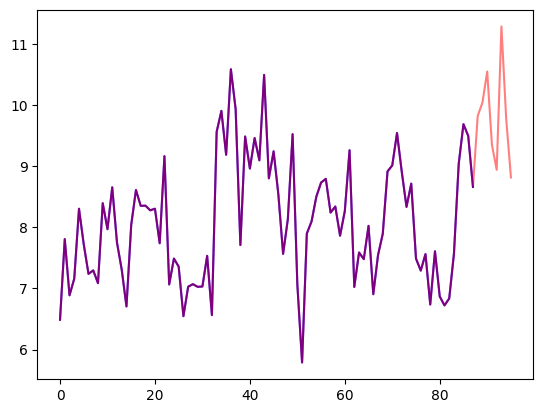

In [16]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots()
axes.plot(train_example["target"], color="blue")
axes.plot(validation_example["target"], color="red", alpha=0.5)

plt.show()

Let's prepare our datasets

In [17]:
train_dataset = dataset["train"]
test_dataset  = dataset["test"]

### Add `start` feature to `pd.Period`
First we convert the `start` dates to pandas `Period` index using the frequency of the data. For time series data, `pandas.Period` is a class to add metadata to the series with information of its frequency.

In [18]:
from functools import lru_cache

import pandas as pd
import numpy as np

freq='1Y'

# lru_cache is a convinient decorator to 
# cache preceding function Least Recent Cache
@lru_cache(10_000)
def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)


def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch

Let's add this to our transformation in our dataloading process.

Run the cell below to see the before and after result (first 5 elements) of this transformation:

In [19]:
train_dataset['start'][:5]

[datetime.datetime(2015, 1, 1, 0, 0),
 datetime.datetime(2015, 1, 1, 0, 0),
 datetime.datetime(2015, 1, 1, 0, 0),
 datetime.datetime(2015, 1, 1, 0, 0),
 datetime.datetime(2015, 1, 1, 0, 0)]

In [20]:
from functools import partial
# parital functions allow creating new functions 
# from pre-defined function with different number of required args  

train_dataset.set_transform(partial(transform_start_field,freq=freq))
test_dataset.set_transform(partial(transform_start_field,freq=freq))

In [21]:
train_dataset['start'][:5]

[Period('2015', 'A-DEC'),
 Period('2015', 'A-DEC'),
 Period('2015', 'A-DEC'),
 Period('2015', 'A-DEC'),
 Period('2015', 'A-DEC')]

## Define the Model

We will train a model from scratch. 

To initialize the model randomly, we will modify the `config` parameters. 

Since we know our dataset, we can add or extra features depending on our knowledge, to help the model. The following additional features are configurable and will be added to our model as parameters.

- `prediction_length` (in our case, `24` months): this is the horizon that the decoder of the Transformer will learn to predict for;
- `context_length`: the model will set the `context_length` (input of the encoder) equal to the `prediction_length`, if none is specified;
- `lags` for a given frequency: these specify how much we "look back" at the past time points. Thus our actual sequence lenght will be `context_length + lags`. This is to be added as additional features. e.g. for a `Daily` frequency `[1, 2, 7, 30, ...]` or in other words look back 1, 2, ... days while for `Minute` data `[1, 30, 60, 60*24, ...]` etc.;
- the number of **time features**: in our case, this will be `2` as we'll add `MonthOfYear` and `Age` features;
- the number of static categorical features: in our case, this will be just `1` as we'll add a single "time series ID" feature;
- the `cardinality` is the number of values of each static categorical feature, as a list which for our case will be `[366]` as we have 366 different time series
- the `embedding dimension`: the embedding dimension for each static categorical feature, as a list, for example `[3]` meaning the model will learn an embedding vector of size `3` for each of the `366` time series (regions).



Let's use the default lags provided by GluonTS for the given frequency ("monthly")

** [GluonTS](https://ts.gluon.ai/stable/) is a Python package for probabilistic time series modeling, focusing on deep learning based models, based on PyTorch and MXNet.

In [22]:
from gluonts.time_feature import get_lags_for_frequency

lags_sequence = get_lags_for_frequency(freq)
print(lags_sequence)

[1, 2, 3, 4, 5, 6, 7]


`lags_sequence` implies that the model will look-back upto 37 months for each time step, as additional features. 

We will also use the default time features defined in GluonTS (returns a `list`)

In [23]:
from gluonts.time_feature import time_features_from_frequency_str

time_features = time_features_from_frequency_str(freq)
print(time_features)

[]


In our case, we have only one time feature, month of year.
This means, for each time step, the timestamps will be encoded as e.g. 1 - January, 2-February, ... etc)

Let's now define the model:

In [24]:
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction

config = TimeSeriesTransformerConfig(
    prediction_length=prediction_length,
    # context length:
    context_length=prediction_length * 2,
    # lags coming from helper given the freq:
    lags_sequence=lags_sequence,
    # we'll add 2 time features ("month of year" and "age", see further):
    num_time_features=len(time_features) + 1,
    # we have a single static categorical feature, namely time series ID:
    num_static_categorical_features=1,
    # it has 366 possible values:
    cardinality=[len(train_dataset)],
    # the model will learn an embedding of size 2 for each of the 366 possible values:
    embedding_dimension=[2],

    # transformer params:
    encoder_layers=4,
    decoder_layers=4,
    d_model=32,
)

model = TimeSeriesTransformerForPrediction(config)

Hugging Face transformers come as modular blocks with a base or headless model architecture and can support predefined heads on top to do different tasks (as long as the base model supports that task). 

Here we use Hugging Face's `TimeSeriesTransformerModel` as base or raw model and for forecasting, a distribution head named `TimeSeriesTransformerForPrediction`. The output of the distribtuion head. 

The distribution head uses Student-t distribution in the Encoder for building self-attention ([check here for possible options](https://huggingface.co/docs/transformers/v4.38.1/en/model_doc/time_series_transformer#transformers.TimeSeriesTransformerModel)).

**This is different from Transformers in NLP where the attention head typically consists of a fixed categorical distribution implemented as an `nn.Linear` layer**. 

## Define transforms

Similar to transforms on images using `torchvision.transforms.Compose` here we use GluonTS to `Chain` some transformations. 

Some of these transformations will add the time features to the data, e.g. month of the year, as an index, as previously discussed.

In [25]:
from gluonts.time_feature import (
    time_features_from_frequency_str,
    TimeFeature,
    get_lags_for_frequency,
)
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)

Below is an example of a set of transformations we seek to be applied to the dataset before the input batch is dispatched to the model. 

These transformations may include:
- removal of certain fields
- addition of static categorical features (FEAT_STATIC_CAT) -- features which donot change over the all timestamps, e.g. time series ID, patient's ID etc
- addition of static real-valued features (FEAT_STATIC_REAL) -- e.g. price of an item in the time series tracking its sale, float16 or 32
- addition of Age feature: an monotonically increasing counter, which keeps track of "at which point in life" a time series is. Age feature helps in positional encoding of the inputs, and unlike in NLP transformers where positional encodings are learnt, these are provided as an additional feature of time series. 


In [26]:
from transformers import PretrainedConfig

# returning transformation, the function below selects feartures to remove
def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    remove_field_names = []
    
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)
        
    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the Time...ForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 4: add temporal features based on freq of the dataset
            # month of year in the case when freq="M"
            # these serve as positional encodings
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in the life the value of the time series is
            # sort of running counter
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            # step 6: vertically stack all the temporal features into the key FEAT_TIME
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )

## Define `InstanceSplitter`
**the window sampler**

An `InstanceSplitter` samples the windows from the dataset. The splitter randomly samples time series  `context_lenght` and `prediction_length` sized chunks and constructs a window. 

*`context_lenght` is the input length to encoder whereas `prediction_length` is the size or length of future horizon or number of predicted points in future* 


The `InstanceSplitter` can be configured into 3 modes:
1. `mode="train"`: Here we sample the context and prediction length windows randomly from the dataset given to it (the training dataset). Both past and future values are included in these samples
2. `mode="validation"`: Here we sample the very last context length window and prediction window from the dataset given to it (for the back-testing or validation likelihood calculations)
3. `mode="test"`: Here we sample the very last context length window only (for the prediction use case)


*`ExpectedNumInstanceSampler`: Keeps track of the average time series length and adjusts the probability per time point such that on average `num_instances` training examples are generated per time series* 

In [27]:
from gluonts.transform.sampler import InstanceSampler
from typing import Optional


def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )

## Create Dataloaders
Now its time to create DataLoaders to:
- ingest data from disk
- apply transformations 
- create batches (`input`:`output` pairs -- in our case past and future values)
- returns an iterator

*`Cached`: a utility wrapper to keep reusable elements of sequences in a list to avoid unnecessary recomputation of deterministic iteratable*

In [28]:
from typing import Iterable

import torch
from gluonts.itertools import Cyclic, Cached
from gluonts.dataset.loader import as_stacked_batches


def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance 
    instance_splitter = create_instance_splitter(config, "train")

    # the instance splitter will sample a window of size
    # context length + lags + prediction length 
    # (from the 366 possible transformed time series)
    # randomly from within the target time series and return an iterator.
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(stream)

    return as_stacked_batches(
        training_instances,
        batch_size=batch_size,
        shuffle_buffer_length=shuffle_buffer_length,
        field_names=TRAINING_INPUT_NAMES,
        output_type=torch.tensor,
        num_batches_per_epoch=num_batches_per_epoch,
    )

Remember from above, the validation set contains the same data as the training set, + `prediction_length` time points more. 

In [29]:
def create_backtest_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data)

    # We create a Validation Instance splitter which will sample the very last
    # context window seen during training only for the encoder.
    instance_sampler = create_instance_splitter(config, "validation")

    # we apply the transformations in train mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=True)

    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )

We also need a `test_loader` for creating instances of test data.
Though we are not using it here, it is added for completness.

In [30]:
def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # We create a test Instance splitter to sample the very last
    # context window from the dataset provided.
    instance_sampler = create_instance_splitter(config, "test")

    # We apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)

    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )

Let's instantiate the dataloaders:

In [31]:
train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=train_dataset,
    batch_size=256,
    num_batches_per_epoch=100,
)

validation_dataloader = create_backtest_dataloader(
    config=config,
    freq=freq,
    data=test_dataset,
    batch_size=64,
)

test_dataloader = create_backtest_dataloader(
    config=config,
    freq=freq,
    data=test_dataset,
    batch_size=64,
)

Let's check the first batch:

In [32]:
%time
batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(f'{k}, {v.shape}, {v.type()}')

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.2 µs
past_time_features, torch.Size([256, 23, 1]), torch.FloatTensor
past_values, torch.Size([256, 23]), torch.FloatTensor
past_observed_mask, torch.Size([256, 23]), torch.FloatTensor
future_time_features, torch.Size([256, 8, 1]), torch.FloatTensor
static_categorical_features, torch.Size([256, 1]), torch.LongTensor
future_values, torch.Size([256, 8]), torch.FloatTensor
future_observed_mask, torch.Size([256, 8]), torch.FloatTensor


The training data is fed to the Encoder stage of transformer. In contrast to the NLP task where Encoder **is not** fed with `input_ids` and `attention_mask` (padding varying lenghts of samples). Instead we are sending :
- `past_values`                 -- input time points `context_length` in length
- `past_observed_mask`          -- (masking NaN's and 0s from numerics which are set to 1s)
- `past_time_features`          -- time features added to the `past_values` during transformations, e.g. `month of the year` and `age` in our case   
- `static_categorical_features`  -- the index in a time series that doesn't change, in our case it is `time_series_id`. For this the model will learn embedding of the dimension `embedding_dimension`  

For the decoder inputs consist of:

- `future_observed_mask`:Boolean mask to indicate which `future_values` were observed and which were missing. Mask values selected in [0, 1]:
   - 1 for values that are observed,
   - 0 for values that are missing (i.e. NaNs that were replaced by zeros).
This mask is used to filter out missing values for the final loss calculation.
- `future_time_features`: these features will be add during transformations, e.g. `month of the year` and `age` in our case. They are `prediction_length` long.
- `future_values`: future values of the time series, that serve as labels for the model. The `future_values` is what the Transformer needs *during training to learn to output*, given the past_values.

## Forward Pass
Let's test a single forward pass with the batch we just created:

In [33]:
# perform forward pass
outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"]
    if config.num_static_categorical_features > 0
    else None,
    static_real_features=batch["static_real_features"]
    if config.num_static_real_features > 0
    else None,
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
    future_observed_mask=batch["future_observed_mask"],
    output_hidden_states=True,
)

In [34]:
%time
print("Loss:", outputs.loss.item())

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.44 µs
Loss: 3.8570237159729004


Note that the model is returning a loss. This is possible as the decoder automatically shifts the `future_values` one position to the right in order to have the labels. This allows computing a loss between the predicted values and the labels.

Also note that the decoder uses a causal mask (to not look into the future as the values it needs to predict are in the `future_values` tensor.

## Train the Model
Now that our `batch` creation and Forward pass appears to be working, let's try and train our model.

To make use of all 8 CPUs available in your notebook instance, we will use 🤗 [Accelerate](https://huggingface.co/docs/accelerate/index) library. It is a convinient way to make the training fast. The library guess an accelerator e.g. a GPU, is available, otherwise falls back on CPU training.  

Here we are using **AdamW** (Adaptive Moment Estimation) as our optimizer. As opposed to stochastic gradient decent (SGD), AdamW converges faster whereas SGD gives more optimal solution. The intuition behind the Adam that it modulates the momentums (first and second order) to adaptive change the it.
(Momentum is an additional term added to the gradient to help move the algorithm faste and avoid stalls in local minima, a classical issue with SGD)

In [35]:
from accelerate import Accelerator
from torch.optim import AdamW

# setup accelerator discovery
accelerator = Accelerator()
device = accelerator.device

# load model to GPU if its there
model.to(device)
# initialize optimizer with hyperparameters
optimizer = AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

# wrap our model, optimizer and data_loader with Accelerate's wrapper. 
# The distribution will be taken care of by Accelerate library 
model, optimizer, train_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
)

# set mode to training. PyTorch will enable use of e.g. dropout or Batch_normalization()
# to avoid overfitting. It also expcets backward pass in this mode.
# These functionalities are not used during inference.
model.train()

# iterate for 10 epochs -- an epoch the model has been 
# presented all the tokens in dataset once. 

for epoch in range(40):
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss

        # Backpropagation
        accelerator.backward(loss)
        optimizer.step()

        if idx % 100 == 0:
            print(f'{epoch}: Loss: {loss.item()}')

0: Loss: 3.8777904510498047
1: Loss: 2.5110697746276855
2: Loss: 1.8304888010025024
3: Loss: 1.648869514465332
4: Loss: 1.5153934955596924
5: Loss: 1.3491206169128418
6: Loss: 1.3508471250534058
7: Loss: 1.2565830945968628
8: Loss: 1.3249571323394775
9: Loss: 1.2763965129852295
10: Loss: 1.3210622072219849
11: Loss: 1.1086676120758057
12: Loss: 1.1535122394561768
13: Loss: 1.330058217048645
14: Loss: 1.188572883605957
15: Loss: 1.186079502105713
16: Loss: 1.2861852645874023
17: Loss: 1.2815083265304565
18: Loss: 1.105137586593628
19: Loss: 1.1584433317184448
20: Loss: 1.116640567779541
21: Loss: 1.1283924579620361
22: Loss: 1.0707849264144897
23: Loss: 1.1145577430725098
24: Loss: 1.146498441696167
25: Loss: 1.2401270866394043
26: Loss: 1.223209261894226
27: Loss: 1.261250376701355
28: Loss: 1.0470516681671143
29: Loss: 1.067491054534912
30: Loss: 1.179149866104126
31: Loss: 1.1158332824707031
32: Loss: 1.2032287120819092
33: Loss: 1.2215884923934937
34: Loss: 1.3133341073989868
35: Lo

## Inference

At inference time, it's recommended to use the `generate()` method for autoregressive generation, similar to NLP models.

Forecasting involves getting data from the test instance sampler, which will sample the very last `context_length` sized window of values from each time series in the dataset, and pass it to the model. Note that we pass `future_time_features`, which are known ahead of time, to the decoder.

The model will autoregressively sample a certain number of values from the predicted distribution and pass them back to the decoder to return the prediction outputs:

In [36]:
## change the mode to eval for inference
model.eval()

forecasts = []

for batch in test_dataloader:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features=batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts.append(outputs.sequences.cpu().numpy())

The model outputs a tensor of shape (`batch_size`, `number of samples`, `prediction length`).

In this case, we get `100` possible values for the next `24` months (for each example in the batch which is of size `64`):

In [37]:
forecasts[0].shape

(64, 100, 8)

We'll stack them vertically, to get forecasts for all time-series in the test dataset:

In [38]:
forecasts = np.vstack(forecasts)
print(forecasts.shape)

(862, 100, 8)


### Quality metric 
We can evaluate the resulting forecast with respect to the ground truth out of sample values present in the test set. For that, we'll use the 🤗 [Evaluate](https://huggingface.co/docs/evaluate/index) library, which includes the [MASE](https://huggingface.co/spaces/evaluate-metric/mase) and [sMAPE](https://huggingface.co/spaces/evaluate-metric/smape) metrics.

#### MASE

Mean Absolute Scaled Error is the mean absolute error of the forecast values, divided by the mean absolute error of the in-sample one-step naive forecast.
Interpretable, as values greater than one indicate that in-sample one-step forecasts from the naïve method perform better than the forecast values under consideration.

#### sMAPE

Symmetric Mean Absolute Percentage Error is the symmetric mean percentage error difference between the predicted and actual values.

This metric is called a measure of “percentage error” even though there is no multiplier of 100. The range is between (0, 2) with it being 2 when the target and prediction are both zero.

**Therefore in both metrics cases, lower is better** 

We calculate both metrics for each time series in the dataset:

In [39]:
from evaluate import load
from gluonts.time_feature import get_seasonality

mase_metric = load("evaluate-metric/mase")
smape_metric = load("evaluate-metric/smape")

forecast_median = np.median(forecasts, 1)

mase_metrics = []
smape_metrics = []
for item_id, ts in enumerate(test_dataset):
    training_data = ts["target"][:-prediction_length]
    ground_truth = ts["target"][-prediction_length:]
    mase = mase_metric.compute(
        predictions=forecast_median[item_id],
        references=np.array(ground_truth),
        training=np.array(training_data),
        periodicity=get_seasonality(freq),
    )
    mase_metrics.append(mase["mase"])

    smape = smape_metric.compute(
        predictions=forecast_median[item_id],
        references=np.array(ground_truth),
    )
    smape_metrics.append(smape["smape"])

In [40]:
print(f"MASE: {np.mean(mase_metrics)}")

MASE: 1.82102712443627


In [41]:
print(f"sMAPE: {np.mean(smape_metrics)}")

sMAPE: 0.13300917976669327


We can also plot the individual metrics of each time series in the dataset and observe that a handful of time series contribute a lot to the final test metric:


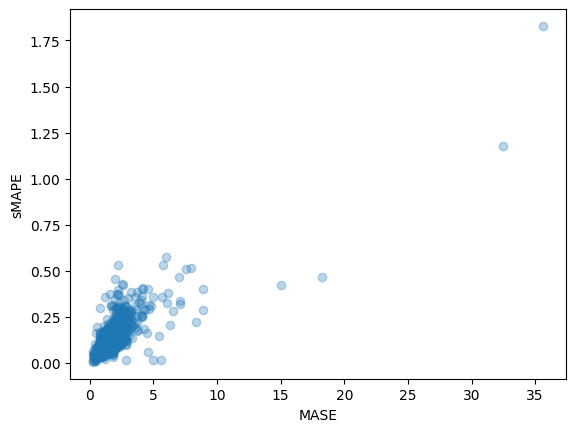

In [42]:

plt.scatter(mase_metrics, smape_metrics, alpha=0.3)
plt.xlabel("MASE")
plt.ylabel("sMAPE")
plt.show()